In [2]:
%matplotlib inline
#%matplotlib widget

In [3]:
#############imports######################################################################
import cv2 as cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import trackpy as tp
import scipy as sc
import matplotlib.colors as colors
import os
from ipywidgets import HBox, Textarea, interact

In [4]:
def read_time(time_value):
    fps=25
    sign_index=time_value.index(':')
    minutes=int(time_value[0:sign_index])
    sec=int(time_value[sign_index+1:len(time_value)])
    frames=(minutes*60+sec)*25
    return frames
#def expShift(t,A,tau,k):
#    return A*np.exp(-t/tau)+k
def expShift(t,A,tau,k):
    return A*np.exp(-(t**2)/((tau**2)))+k
#def CovToCorr(cov_data):
#    shape=cov_data.shape
#    result=[]
#    for i in range(0,shape):
def powerlaw(x,A,n):
    return A*x**n
def linear_fit_log(x,n,A):
    return n*x+A
    

In [5]:
expSumFileNamePassive='C:\\Users\\User\\Documents\\Eden\\locate_git_code\\packaged\\expSumPack21.csv'
expSumPassive=pd.read_csv(expSumFileNamePassive,index_col=0)
passive_path='C:\\Users\\User\\Documents\\Eden\\locate_git_code\\packaged'
all_data=pd.DataFrame()
for index,row in expSumPassive.iterrows():
    #bot experiment loop
    FileName=row.linkingFileNamePack
    starting_frame=read_time(row.start_min)
    bot_num_current=row.bots
    data=pd.read_csv(passive_path+'\\'+FileName,index_col=0)
    relevant_data=data.iloc[starting_frame:len(data)].reset_index()
    relevant_data['Filename']=[FileName]*len(relevant_data)
    relevant_data['BotNum']=[row.bots]*len(relevant_data)
    relevant_data['BotType']=[row.bottype]*len(relevant_data)
    all_data=pd.concat([all_data,relevant_data],axis=0)
all_data.to_csv(passive_path+'\\all_linking_passive_data_21bots.csv')

In [13]:
arenaSizePixels = 1090 # [pixels]
arenaSizeCm = 150 # [cm]
fps =25
mpp = arenaSizeCm/arenaSizePixels/2 #[cm/pixel]
power_law=pd.DataFrame()
for index,row in expSumPassive.iterrows():
    FileName=row.linkingFileNamePack
    print(FileName)
    current_data=all_data[(all_data['Filename']==FileName)]
    relevant_data_try = tp.filter_stubs(current_data,threshold=100)
    max_lagtime=int(len(relevant_data)/3)
    imsd = tp.imsd(current_data,fps=fps,mpp=mpp,max_lagtime=max_lagtime)
    last_imsd_try=imsd.index[-1]
    lag_time_thresh=int(last_imsd_try/150)
    max_lagtime_thresh=int(last_imsd_try/3)
    relevant_imsd_max=imsd.loc[lag_time_thresh:max_lagtime_thresh]
    relevant_imsd_min=imsd.loc[10:50]
    p0=np.array([2,0.5])
    popt_max,pcov_max = sc.optimize.curve_fit(linear_fit_log,np.log(relevant_imsd_max.index),np.log(relevant_imsd_max.iloc[:,0]),p0=p0)
    perr_max = np.sqrt(np.diag(pcov_max))
    corr_max=np.corrcoef(pcov_max,rowvar=True)
    popt_min,pcov_min = sc.optimize.curve_fit(linear_fit_log,np.log(relevant_imsd_min.index),np.log(relevant_imsd_min.iloc[:,0]),p0=p0)
    perr_min = np.sqrt(np.diag(pcov_min))
    corr_min=np.corrcoef(pcov_min,rowvar=True)
    data_row=pd.DataFrame()
    data_row['FileName']=[FileName]
    data_row['n_max']=[popt_max[0]]
    data_row['n_max_err']=[perr_max[0]]
    data_row['A_max']=[np.exp(popt_max[1])]
    data_row['A_max_err']=[perr_max[1]]
    data_row['n_min']=[popt_min[0]]
    data_row['n_min_err']=[perr_min[0]]
    data_row['A_min']=[np.exp(popt_min[1])]
    data_row['A_min_err']=[perr_min[1]]
    data_row['Bot_Type']=row.bottype
    data_row['diameter']=row['passiveDiameter[cm]']
    power_law=pd.concat([power_law,data_row],axis=0)
print(power_law)
power_law.to_csv(passive_path+'\\power_law_21_bots.csv')

aligner_N021_D007_C0548.MP4_link.csv
aligner_N021_D007_C0547.MP4_link.csv
aligner_N021_D007_C0544.MP4_link.csv
aligner_N021_D007_C0542.MP4_link.csv
fronter_N021_D007_C0541.MP4_link.csv
fronter_N021_D007_C0540.MP4_link.csv
fronter_N021_D007_C0539.MP4_link.csv
fronter_N021_D007_C0538.MP4_link.csv
fronter_N021_D012_C0537.MP4_link.csv
fronter_N021_D012_C0536.MP4_link.csv
fronter_N021_D012_C0535.MP4_link.csv
fronter_N021_D012_C0534.MP4_link.csv
fronter_N021_D012_C0533.MP4_link.csv
aligner_N021_D012_C0532.MP4_link.csv
aligner_N021_D012_C0531.MP4_link.csv
aligner_N021_D012_C0530.MP4_link.csv
aligner_N021_D012_C0529.MP4_link.csv
aligner_N021_D018_C0527.MP4_link.csv
aligner_N021_D018_C0526.MP4_link.csv
aligner_N021_D018_C0525.MP4_link.csv
aligner_N021_D018_C0523.MP4_link.csv
fronter_N021_D018_C0521.MP4_link.csv
fronter_N021_D018_C0519.MP4_link.csv
fronter_N021_D018_C0514.MP4_link.csv
fronter_N021_D018_C0516.MP4_link.csv
fronter_N021_D018_C0517.MP4_link.csv
fronter_N021_D028_C0490.MP4_link.csv
f

In [14]:
mean_data=power_law.groupby(by=["Bot_Type","diameter"]).mean()
print(mean_data.loc[("fronter","n_min")])
std_data=power_law.groupby(by=["Bot_Type","diameter"]).std()
print(std_data)

diameter
7     1.060399
12    1.319023
18    1.521532
28    1.526883
32    1.642393
Name: n_min, dtype: float64
                      n_max  n_max_err     A_max  A_max_err     n_min  \
Bot_Type diameter                                                       
aligner  7         0.091022   0.000330  0.116539   0.001244  0.077893   
         12        0.238049   0.004058  1.163321   0.015325  0.236138   
         18        0.095827   0.000898  0.038077   0.003390  0.113897   
         28        0.250287   0.000716  0.025735   0.002703  0.219531   
         32        0.427091   0.000974  0.199948   0.003680  0.462936   
fronter  7         0.133693   0.000654  0.109670   0.002489  0.131387   
         12        0.296189   0.002412  0.434210   0.009353  0.214748   
         18        0.145227   0.001241  0.057240   0.004854  0.124477   
         28        0.222947   0.000776  0.041343   0.002930  0.232963   
         32        0.207300   0.002939  0.019944   0.011097  0.127605   

           

C:\Users\User\AppData\Local\Temp\ipykernel_25040\1594602924.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_data=power_law.groupby(by=["Bot_Type","diameter"]).mean()
C:\Users\User\AppData\Local\Temp\ipykernel_25040\1594602924.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std_data=power_law.groupby(by=["Bot_Type","diameter"]).std()


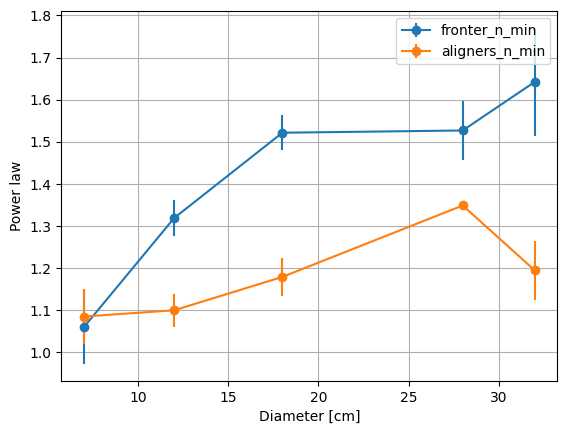

In [18]:
fronter_data=mean_data.loc[("fronter","n_min")]
fronter_data_max= mean_data.loc[("fronter","n_max")]
fronter_diff=fronter_data-fronter_data_max
aligner_data=mean_data.loc[("aligner","n_min")]
aligner_data_max=mean_data.loc[("aligner","n_max")]
aligner_diff=aligner_data-aligner_data_max
fig,ax = plt.subplots()
ax.errorbar(x=fronter_data.index,y=fronter_data,marker='o',label='fronter_n_min',yerr=np.abs(fronter_diff.to_numpy()))
#ax.plot(fronter_data_max.index,fronter_data_max,'-o',label='fronter_n_max')
ax.errorbar(x=aligner_data.index,y=aligner_data,marker='o',label='aligners_n_min',yerr=np.abs(aligner_diff.to_numpy()))
#ax.plot(aligner_data_max.index,aligner_data_max,'-o',label='aligners_n_max')
ax.set_xlabel('Diameter [cm]')
ax.set_ylabel('Power law')
ax.grid()
ax.legend()